In [2]:
import gzip
import json
from pathlib import Path
from typing import Union
import numpy as np
import h5py
import tqdm
import trimesh


In [3]:
dataset = "data/demos/PegInsertionSide-v0/trajectory.rgbd.pd_joint_delta_pos_gt.h5"
ground_truth = "data/demos/PegInsertionSide-v0/trajectory.pointcloud.pd_joint_delta_pos_gt.h5"

def load_json(filename: Union[str, Path]):
    filename = str(filename)
    if filename.endswith(".gz"):
        f = gzip.open(filename, "rt")
    elif filename.endswith(".json"):
        f = open(filename, "rt")
    else:
        raise RuntimeError(f"Unsupported extension: {filename}")
    ret = json.loads(f.read())
    f.close()
    return ret

def load_h5_data(data):
    out = dict()
    for k in data.keys():
        if isinstance(data[k], h5py.Dataset):
            out[k] = data[k][:]
        else:
            out[k] = load_h5_data(data[k])
    return out

def convert_observation(observation):
    # combines the rgb and depth images
    # image data is not scaled here and is kept as uint16 to save space
    image_obs = observation["image"]
    rgb = image_obs["base_camera"]["rgb"]
    depth = image_obs["base_camera"]["depth"]
    rgb2 = image_obs["hand_camera"]["rgb"]
    depth2 = image_obs["hand_camera"]["depth"]

    # combine the RGB and depth images
    rgbd = np.concatenate([rgb, depth, rgb2, depth2], axis=-1)
    obs = dict(rgbd=rgbd)
    return obs

def rescale_rgbd(rgbd, scale_rgb_only=False, discard_depth=False,
                 separate_cams=True):
    # rescales rgbd data and changes them to floats
    rgb1 = rgbd[..., 0:3] / 255.0
    rgb2 = rgbd[..., 4:7] / 255.0
    depth1 = rgbd[..., 3:4]
    depth2 = rgbd[..., 7:8]
    if not scale_rgb_only:
        depth1 = rgbd[..., 3:4] / (2**10)
        depth2 = rgbd[..., 7:8] / (2**10)
    
    if discard_depth:
        if separate_cams:
            rgbd = np.stack([rgb1, rgb2], axis=-1)
        else:
            rgbd = np.concatenate([rgb1, rgb2], axis=-1)
    else:
        if separate_cams:
            rgbd = np.stack([np.concatenate([rgb1, depth1], axis=-1), 
                             np.concatenate([rgb2, depth2], axis=-1)], axis=-1)
        else:
            rgbd = np.concatenate([rgb1, depth1, rgb2, depth2], axis=-1)

    return rgbd

In [4]:
# Load the input data
input_data = h5py.File(dataset, "r")
json_path = dataset.replace(".h5", ".json")
input_json= load_json(json_path)
input_eps = input_json["episodes"]

# Load the ground truh data
gt_data = h5py.File(ground_truth, "r")
gt_json_path = ground_truth.replace(".h5", ".json")
gt_json= load_json(gt_json_path)
gt_eps = gt_json["episodes"]

In [5]:
# Filter an observation down to a singular RGBD image, raw, no pre-procressing
ep = input_eps[0]
traj = input_data["traj_0"]
traj = load_h5_data(traj)

obs = convert_observation(traj["obs"])
rgbd = obs["rgbd"][:-1]
rgbd = rescale_rgbd(rgbd)
rgbd = rgbd.transpose((0, 4, 1, 2, 3))
seq = rgbd[0]
cam = seq[0]
ex_cv = cam2world = traj["obs"]["camera_param"]["base_camera"]["extrinsic_cv"][:-1][0]
in_cv = cam2world = traj["obs"]["camera_param"]["base_camera"]["intrinsic_cv"][:-1][0]

origin = np.eye(3)


In [10]:
print(in_cv)

[[64.  0. 64.]
 [ 0. 64. 64.]
 [ 0.  0.  1.]]


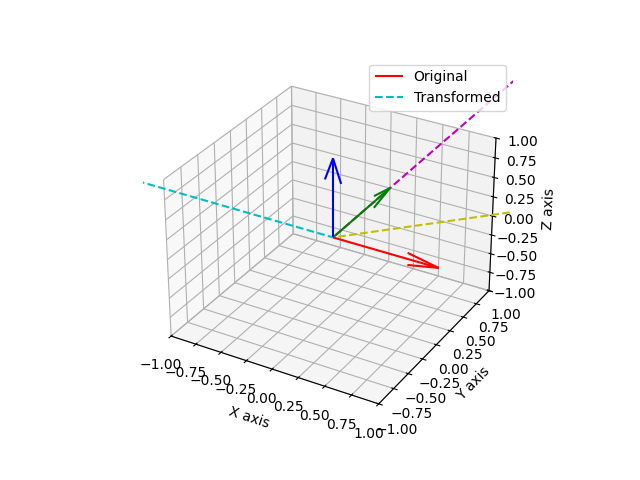

In [12]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the original axes (standard basis vectors)
origin = np.array([0, 0, 0])
x_axis = np.array([1, 0, 0])
y_axis = np.array([0, 1, 0])
z_axis = np.array([0, 0, 1])

# Create the original axes matrix
original_axes = np.array([x_axis, y_axis, z_axis])

# Define a random transformation matrix
transformation_matrix = cam2world[:3, :3]

# Apply the transformation matrix to the original axes
transformed_axes = transformation_matrix @ original_axes.T

# Set up the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the original axes
ax.quiver(origin[0], origin[1], origin[2], 
          original_axes[:, 0], original_axes[:, 1], original_axes[:, 2], 
          color=['r', 'g', 'b'], label='Original Axes')

# Plot the transformed axes
ax.quiver(origin[0], origin[1], origin[2], 
          transformed_axes[0], transformed_axes[1], transformed_axes[2], 
          color=['c', 'm', 'y'], linestyle='dashed', label='Transformed Axes')

# Set plot limits
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

# Labels and legend
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.legend(['Original', 'Transformed'])

# Show the plot
plt.show()
